The Cox Ingersoll Rosee Model
$$ dr_t = a(b-r_t)dt + {\sigma}{\sqrt[]{r_t}}dW_t $$

## Short Rate vs Annualized

In general, if we compound every 1/N of a year (i.e N times a year) we get:

$$\left(1+\frac{r}{N}\right)^N$$

As N becomes very large we get the generalization

$$ 1+r_{annual}=e^{r_{inst}} $$

i.e.

$$ r_{annual}=e^{r_{inst}} - 1 $$

and

$$ r_{inst} = ln{(1+r_{annual})} $$

In [36]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

def inst_to_ann(r):
    """
    Converts short rate to an annualized rate
    """
    return np.expm1(r) #np.exp(r)-1

def ann_to_inst(r):
    """
    Convert annualized to a short rate
    """
    return np.log1p(r)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$$ dr_t = a(b-r_t)dt + {\sigma}{\sqrt[]{r_t}}dW_t $$

In [37]:
def cir(n_years = 10, n_scenarios=1,a=0.05,b=0.03,sigma=0.05,steps_per_year=12,r_0=None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0) #Unless interest rate is large, this shouldn't change rate by a lot
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year)+1 #step = 120 + 1
    #print(num_steps)
    shock = np.random.normal(0,scale=np.sqrt(dt),size=(num_steps, n_scenarios))
    rates = np.empty_like(shock) #creating a DataFrame in the same scale as shock
    rates[0] = r_0
    for step in range(1,num_steps): #range(1,121)
        r_t = rates[step-1]
        #print(r_t)
        d_r_t = a * (b-r_t) + sigma*np.sqrt(r_t)*shock[step]
        #print(step) #debugg
        rates[step] = abs(r_t + d_r_t) #abs inserted to avoid neg rates
        
    #return (pd.DataFrame(data=inst_to_ann(rates),index=range(num_steps)),shock)
    return pd.DataFrame(data=inst_to_ann(rates))

In [38]:
cir(n_scenarios=3)

,0,1,2
0,0.030000,0.030000,0.030000
1,0.030155,0.025223,0.030392
2,0.032968,0.026141,0.031467
3,0.034051,0.022368,0.030000
4,0.032125,0.021560,0.032038
...,...,...,...
116,0.042909,0.041675,0.019560
117,0.045244,0.042294,0.023163
118,0.040103,0.045568,0.027528
119,0.039030,0.042481,0.027260


(0.0, 120.0, 0.02476109046936569, 0.03607438565186521)

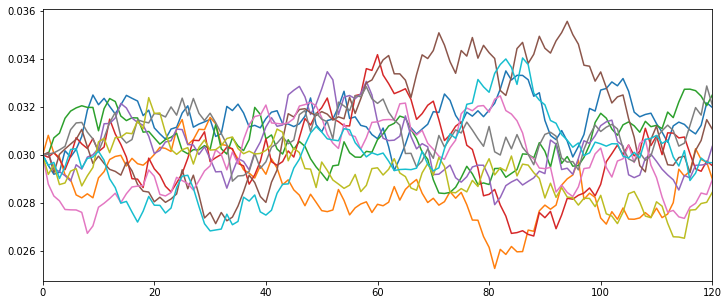

In [39]:
ax = cir(n_scenarios=10, sigma=0.01).plot(figsize=(12,5),legend=False)
ax.axis(xmin=0)
ax.axis(xmax=120)

In [40]:
def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir_plot = cir(r_0=r_0, a=a,b=b,sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,5))
    cir_plot.axis(xmin=0)
    cir_plot.axis(xmax=120)
    
import ipywidgets as widgets
from IPython.display import display

controls = widgets.interactive(show_cir,
                              r_0 = (0, .15, .01),
                              a = (0,1,.1),
                               b = (0, .15, .01),
                               sigma=(0,.1,.01),
                               n_scenarios = (1,100)
                              )
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

the model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and 
$$ h={\sqrt {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$

In [41]:
import math
def cir(n_years = 10, n_scenarios=1,a=0.05,b=0.03,sigma=0.05,steps_per_year=12,r_0=None):
    """
    Generate random interest rate evolution over time using the CIPR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps = int(n_years*steps_per_year) + 1 #121 = 10*12 +1 
    
    shock = np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm,r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        # generate prices at time t as well
        prices[step] = price(n_years-step*dt,rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates),index=range(num_steps))
    ## for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    ###
    return rates, prices

In [42]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir_plot = cir(r_0=r_0, a=a,b=b,sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))
    cir_plot.axis(xmin=0)
    cir_plot.axis(xmax=120)
    
controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0,1,.1),
                               b = (0, .15, .01),
                               sigma=(0,.1,.01),
                               n_scenarios = (1,100)
                              )
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [61]:
a_0 = .75 #initial asset value
rates, bond_prices = cir(r_0 = 0.03, b=0.03,n_scenarios=10, n_years=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1],index=[10])
zc_0 = erk.pv(zcbond_10,r=0.03) 
n_bonds = a_0/zc_0
av_zc_bonds=n_bonds*bond_prices #asset value if in bond
av_cash = a_0*(rates/12+1).cumprod() #asset value if in cash

<AxesSubplot:>

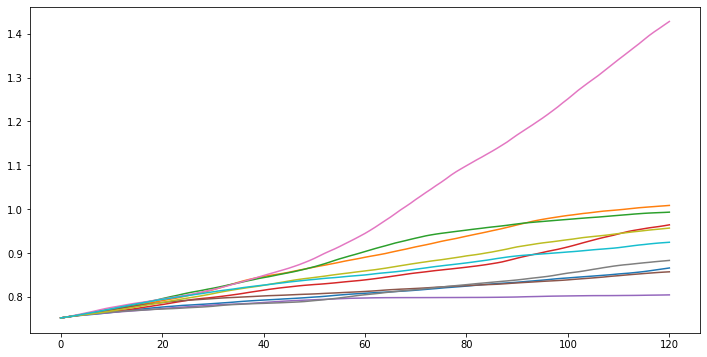

In [51]:
av_cash.plot(legend=False, figsize=(12,6))

<AxesSubplot:>

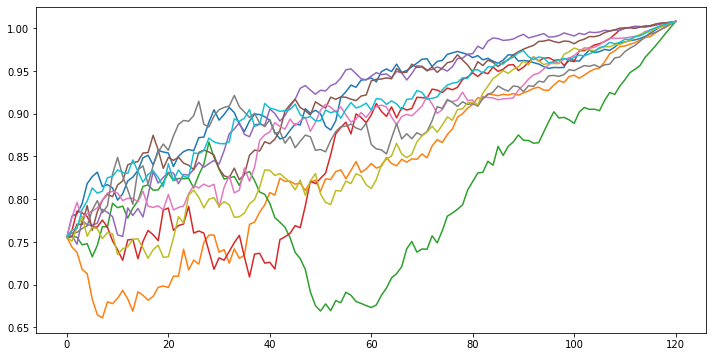

In [56]:
av_zc_bonds.plot(legend=False, figsize=(12,6))

## Funding Ratios

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash (10 scenarios)'}>

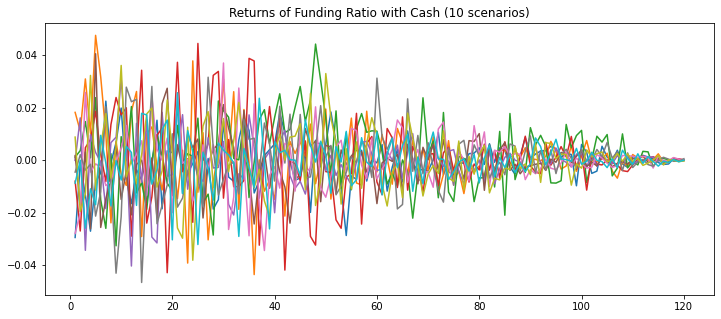

In [57]:
(av_cash/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

<AxesSubplot:title={'center':'Returns of Funding Ratio with Cash (10 scenarios)'}>

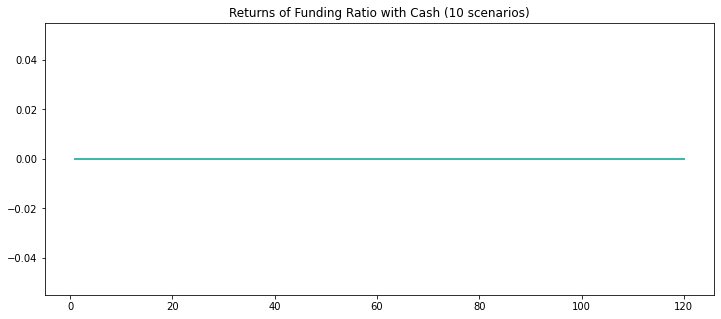

In [62]:
(av_zc_bonds/liabilities).pct_change().plot(title='Returns of Funding Ratio with Cash (10 scenarios)', legend=False, figsize=(12,5))

In [64]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

<AxesSubplot:>

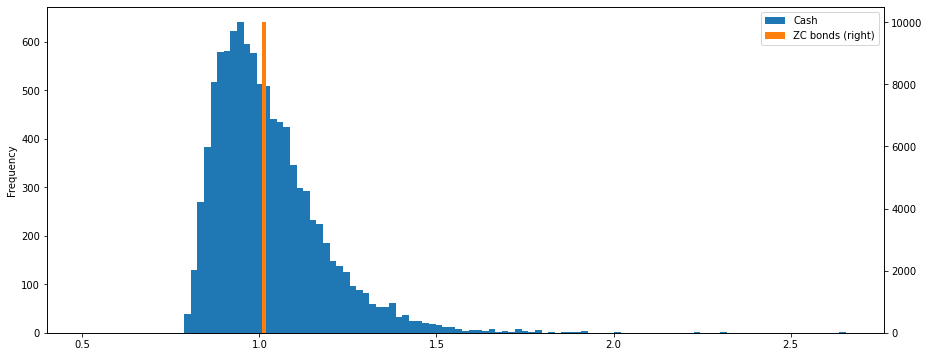

In [67]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]  #terminal funding ratio
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]  #terminal funding ratio
ax = tfr_cash.plot.hist(label="Cash",figsize=(15,6),bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label="ZC bonds",bins=100,legend=True, secondary_y=True)